**MODULES**

In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
import torch.optim as optim

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import math

**ICIFAR100**

In [2]:
class iCIFAR10(CIFAR10):
  def __init__(self, root,classes,train,transform=None,target_transform=None,download=False):
    super(iCIFAR10, self).__init__(root,train=train,transform=transform,target_transform=target_transform,download=download)
    
    train_data = []
    train_labels = []

    for i in range(len(self.data)):
      if self.targets[i] in classes:
        train_data.append(self.data[i])
        train_labels.append(self.targets[i])

    self.data = np.array(train_data)
    self.targets = train_labels
  
  def __getitem__(self, index):
    img, target = self.data[index], self.targets[index]
    img = Image.fromarray(img)
    
    if self.transform is not None:
      img = self.transform(img)
    
    if self.target_transform is not None:
      target = self.target_transform(target)
    
    return index, img, target

  def __len__(self):
    return len(self.data)

  def get_image_class(self, label):
    return self.data[np.array(self.targets) == label]

  def append(self, images, labels):
    self.data = np.concatenate((self.data, images), axis=0)
    
    self.targets = self.targets + labels

class iCIFAR100(iCIFAR10):
    base_folder = 'cifar-100-python'
    url = "http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]
    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }

**MODEL**

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=0): #SAREBBE num_classes=10
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, toExtract):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        if toExtract==True:
          return x
        else:
          x = self.fc(x)
          return x

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

**Set Argument**

In [4]:
DEVICE = 'cuda'    
BATCH_SIZE = 128
LR = 0.2        
NUM_EPOCHS = 70
MILESTONE=[49,63]
WEIGHT_DECAY = 0.00001
MOMENTUM=0.9 
GAMMA = 0.2
K = 2000 

In [5]:
def create_weigth(n_oldclasses):
  if n_oldclasses==0:
    lista=[1 for i in range(10)]
  else:
    value=500/(2000/n_oldclasses)
    lista_old=[value for i in range(n_oldclasses)]
    lista_new=[1 for i in range(10)]
    lista=lista_old+lista_new
  return lista

In [6]:
class iCaRLNet(nn.Module):
  # def __init__(self, n_classes):
  def __init__(self):
    super(iCaRLNet, self).__init__()
    self.net = resnet32()                 #net given
    self.n_classes = 0                    #total number of classes up to now 
    self.classes_known=[]                 #list of all classes seen up to now
    self.new_classes=[]                   #list new classes at every step
    self.dic={}                           #dictionary used to map class label from 0 to n_classes according to the order of classes
    self.count_per_dic=0                  #to count the number of element in the dictionary
    self.exemplar_sets = []               #list where elements are lists containg all the examplar of that class (saved as numpy array)        
    self.exemplar_sets_labels=[]          #list to know the label of exemplars
    self.all_labels=[]                    #list of all labels seen up to now                    
    self.loss=BCEWithLogitsLoss()         #loss used
    self.compute_means = True             #flag to compute the mean only once during the classification
    self.exemplar_means = []              #list containg the mean of each exemplars' class
    self.distillation_loss=BCEWithLogitsLoss()
    # self.classification_loss=CrossEntropyLoss(reduction="none")
    
    
  def forward(self, x, toExtract=False):  #toExtract=True -> gives the features (results of convolutional layers), toExtract=False -> gives the output of the fully connected
    x = self.net(x, toExtract)
    return x

  def classify(self, x, train_set,transform):
    self.net.train(False) #no training anymore
    with torch.no_grad():
      batch_size = x.size(0) #128, batch_size
      if self.compute_means:  #computing mean only once, at the first iteration
        print("Now the means of exemplars are computed")
        exemplar_means = []
        count=-1
        for P_y in self.exemplar_sets:  #P_y are all the exemplars of class y
          count+=1
          features = []
          classe_giusta=self.exemplar_sets_labels[count] #take the original class (from the mapped to the real one)
          if classe_giusta not in self.new_classes: #if the image is old,it's taken from the exemplars set
            for ex in P_y:
              ex = transform(Image.fromarray(ex)).cuda()
              feature = self.net(ex.unsqueeze(0),True)
              feature = feature.squeeze()
              feature.data = feature.data/ feature.data.norm() # normalization
              features.append(feature)
          if classe_giusta in self.new_classes: #if the image is new, it's taken from the train set
            img_classes=train_set.get_image_class(classe_giusta)
            for immagine in img_classes:
              im = transform(Image.fromarray(immagine)).cuda()
              feature = self.net(im.unsqueeze(0),True)
              feature = feature.squeeze()
              feature.data = feature.data/ feature.data.norm() # normalization
              features.append(feature)
          features = torch.stack(features) #stack features of exemplars and images from train all together 
          mu_y = features.mean(0).squeeze() #mean of the class y
          mu_y.data = mu_y.data / mu_y.data.norm() # normalization
          exemplar_means.append(mu_y) #saving mean
        self.exemplar_means = exemplar_means
        self.compute_means = False #to not compute again within the same loader (will be set to true in update_representation) 
        print ("Finish")
        
      exemplar_means = self.exemplar_means #to retrieve the value computed at the first iteration on the loader
      means = torch.stack(exemplar_means)   #[10,64] becomes an unique tensor with 10 elements (length=64), then 20,.....

      means = torch.stack([means] * batch_size) #torch.Size([128, 10, 64]) [batch_size,n_classes,feature_size]

      means = means.transpose(1, 2)  #torch.Size([128, 64, 10]) [batch_size,feature_size,n_classes]
      
      feature = self.net(x,True)  # feature representation is extracted for the images x that have to be classified (tensor[128,64])
      for i in range(feature.size(0)): #for each image in the batch
        feature.data[i] = feature.data[i] / feature.data[i].norm() #feature.data[i] it's a tensor 64 (feature representation of image i)
      feature = feature.unsqueeze(2) #from [128,64] to [128,64,1]
      feature = feature.expand_as(means) #[128,64,10]

      dists = (feature - means).pow(2).sum(1).squeeze()    #[128,10] [batch_size,n_classes]
      _, preds = dists.min(1) #index which corresponds to the minimum distance (from 0 to 9 for the first 10 classes)    
    
      listMap=[]
      for el in preds:
        listMap.append(self.exemplar_sets_labels[el.item()])  #to map to the real classes
    
      preds=torch.tensor(listMap) #from list to tensor
      return preds

  def increment_classes(self, new_classes):
    self.new_classes=[]     #list used to save only the new classes for each step  
    for classe in new_classes:  
      if classe not in self.classes_known:        #to avoid duplicates
        self.classes_known.append(classe)                  
        self.n_classes += 1   
        self.new_classes.append(classe)
    in_features = self.net.fc.in_features                  
    out_features = self.net.fc.out_features
    weight = self.net.fc.weight.data
    bias = self.net.fc.bias.data
    self.net.fc = nn.Linear(in_features, out_features+len(self.new_classes), bias=True)
    self.net.fc.weight.data[:out_features] = weight   #copy old weights
    self.net.fc.bias.data[:out_features] = bias       #copy old biases

  def construct_exemplar_set(self,y, images, m, transform): #transform is needed because images are numpy, but we have to pass them through the network to extract the feature vector and so they have to be tensor
    self.net.train(False) 
    with torch.no_grad(): 
      features = []          #here we save the convolutional layers output of all the images (of the train set) belonging to that class (y) (feature representation)
      for img in images:
        x = transform(Image.fromarray(img)).cuda()                    #img is a numpy, Image.fromarray(img) is a PIL image, x becomes a tensor
        feature = self.net(x.unsqueeze(0),True).data.cpu().numpy()    #feature representation (toExtract=True), unsqueeze is needed because we are passing only one image
        feature = feature / np.linalg.norm(feature)                   #normalization
        features.append(feature[0])                                   #normalized feature of the image

      features = np.array(features)                                 #numpy.array of 500 elements (only images from class y), each of them has len=64 (output size)
      class_mean = np.mean(features, axis=0)                        #len=64, compute the class mean
      class_mean = class_mean / np.linalg.norm(class_mean)          #normalization
        
      exemplar_set = []
      exemplar_features = []
      for k in range(m):        #searching best exemplars
        S = np.sum(exemplar_features, axis=0)     #first run shape=0, then it's a numpy.array with 64 elements
        phi = features    #numpy with the features of the images, but when an image is chosen as exemplar, it's removed from this array
        mu = class_mean
        mu_p = 1.0/(k+1) * (phi + S)     #at the beginning [500,64], then [499,64]
        mu_p = mu_p / np.linalg.norm(mu_p)   #normalization
        i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))   #take the exemplar with the smallest distance from the class mean 
        exemplar_set.append(images[i])    #save it
        exemplar_features.append(features[i]) #save its features representation
        features=np.delete(features,i,axis=0) #remove the chosen image (otherwise we waste space with duplicates)
      self.exemplar_sets.append(np.array(exemplar_set))      #It's a list in which each element (exemplar_set) is transformed in a numpy.array with length 200 and each element(image) has length 32 (32*32) (because it's a numpy)
      self.exemplar_sets_labels.append(y)              
         

  def reduce_exemplar_sets(self, m):
    for y, P_y in enumerate(self.exemplar_sets):
      self.exemplar_sets[y] = P_y[:m]       #select only the first m exemplars (the most important)


  def combine_dataset_with_exemplars(self, dataset):
    for y, P_y in zip(self.exemplar_sets_labels,self.exemplar_sets):
      exemplar_images = P_y #all exemplars of class y
      exemplar_labels = [y] * len(P_y)  #to have list containg the real label for all the exemplars belonging to that class
      dataset.append(exemplar_images, exemplar_labels)  #now the training set has also the exemplars of the previous classes
    # return dataset
       
  def update_representation(self, dataset):
    self.compute_means=True     #since there are new classes the means have to be computed          
    
    classes = list(set(dataset.targets))      #total distinct labels in the trainig set
    self.increment_classes(classes)           #to increment output size of the net, since new classes are added
    self.cuda()     
    print (f"Now there are {self.n_classes} classes")
    
    optimizer = optim.SGD(self.net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY,momentum=MOMENTUM)
    scheduler=optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONE, gamma=GAMMA)

    self.combine_dataset_with_exemplars(dataset)      #add old exemplars to training set

    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

    q = torch.zeros(len(dataset), self.n_classes).cuda()  #to initialize q, otherwise q[slice] can't be performed
    
    for indices, images, labels in loader:
      images = images.to(DEVICE)
      indices = indices.to(DEVICE)
      g = torch.sigmoid(self.forward(images,False))       #sigmoid of outputs of the old network
      q[indices] = g.data                                 #save in this way in order to retrieve the correct q for each image when the loss is calculated in the new network
      q = q.cuda()

    order_label=[]          
    for i, (indices, images, labels) in enumerate(loader):
      for label in labels:
        if label not in self.all_labels:                  #excluding exemplars
          if label not in order_label:                    #taking only once the new labels
            order_label.append(label)                     
            self.dic[label.item()]=self.count_per_dic #construct the dictionary that will be used for mapping the output of the fully connected layer. 
                                                      #The first class seen will correspond to the output of the first neuron (which is the first column in g) and so on
            self.count_per_dic +=1  
            self.all_labels.append(label)             #append the new label to the total labels list
        
    for epoch in range(NUM_EPOCHS):
      for i, (indices, images, labels) in enumerate(loader):
        indices = indices.cuda()
        images = images.cuda()
        labels = labels.cuda()

        mapped_labels=[]  #map labels of images in the batch, len=batch_size
        for label in labels:
          mapped_labels.append(self.dic[label.item()])
        
        oneHot=torch.nn.functional.one_hot(torch.tensor(mapped_labels),self.n_classes)   #return the one hot matrix with
                                                                                              #number of columns=self.n_classes
                                                                                              #number of rows=number of images in the batch
                                                                                              #each row has 1 in the column corresponding to the correct label, 0 otherwise
        oneHot=oneHot.type(torch.FloatTensor)   #convert to type float to match with q and g type
        oneHot=oneHot.cuda()
                
        self.net.train()       #start training
        optimizer.zero_grad()   #to delete the accumulated gradients
        g = self.forward(images)  #scores given by the updated network, (fully connected outputs)
        lista_map=[]  #map NEW CLASS, len=10
        for classe in self.new_classes:
          lista_map.append(self.dic[classe])

        old_classes=[item for item in self.classes_known if item not in self.new_classes]
        old_classes_mapped=[] #map OLD CLASS, len=10,20,30.....
        for classe in old_classes:
          old_classes_mapped.append(self.dic[classe])
        tot_mapped=old_classes_mapped+lista_map

        loss_dist=0.0
        #DISTILLATION SOLO SULLE VECCHIE
        if len(old_classes) > 0:
          q_i = q[indices]
          loss_dist = self.distillation_loss(g[:,old_classes_mapped], q_i[:,old_classes_mapped])
        output=g  
        lista_map_tensore=torch.tensor(mapped_labels).cuda()
        weight_list=create_weigth(len(old_classes))
        weight_tensor=torch.tensor(weight_list)
        weight_tensor=weight_tensor.type(torch.FloatTensor).cuda()
        classification_loss=CrossEntropyLoss(weight=weight_tensor)
        loss_class=classification_loss(output,lista_map_tensore)
        loss=loss_dist+loss_class
      

        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
          print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Iter: {i+1}/{math.ceil(len(dataset)/BATCH_SIZE)}, Loss: {loss.item():.4f}, lr={scheduler.get_last_lr()[0]} ")

      scheduler.step()

**MAIN**

In [7]:
def give_split():
  x=np.arange(0,100)
  x=x.tolist()
  random.seed(34)
  random.shuffle(x)
  total_classes=[]
  for i in range(0,100,10):
    lista=x[i:i+10]
    total_classes.append(lista)
  return total_classes

In [8]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

icarl = iCaRLNet()
icarl.cuda()


list_classes=give_split()
lista_tot=[]

list_train_acc=[]
list_test_acc=[]

for s in range(0,len(list_classes)):
  for elem in list_classes[s]:              #creating the list with all the classes seen up to now to create the test set
    lista_tot.append(elem)

  print(f"Classes in training set: {list_classes[s]}")
  print(f"Classes in test set: {lista_tot}")

  train_set = iCIFAR100(root='./data',train=True,classes=list_classes[s],download=True,transform=transform_train)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,shuffle=True, num_workers=2)

  test_set = iCIFAR100(root='./data',train=False,classes=lista_tot,download=True,transform=transform_test)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,shuffle=False, num_workers=2)

  icarl.update_representation(train_set)     # Update network
  m = int(K / icarl.n_classes)    #m is maximum number of exemplars for each class

  icarl.reduce_exemplar_sets(m)   # Reduce exemplar sets for known classes

  for y in icarl.new_classes:   # Construct exemplar sets for new classes
    print(f"Constructing exemplar set for class: {y}")
    images= train_set.get_image_class(y)  #numpy.ndarray of all images of the training set belonging to class y
    icarl.construct_exemplar_set(y,images,m, transform_test)  #y=class, images=numpy..., m=number of exemplars to save, transform test because it's needed 
  print("Finish")

  total = 0.0
  correct = 0.0
  for indices, images, labels in train_loader:
    images = images.cuda()
    preds = icarl.classify(images, train_set,transform_test)
    total += labels.size(0)
    correct += (preds.data.cpu() == labels).sum()
    
  train_accuracy = correct / total

  print(f'Train Accuracy: {train_accuracy}')
  list_train_acc.append(train_accuracy)

  total = 0.0
  correct = 0.0
  for indices, images, labels in test_loader:
    images = images.cuda()
    preds = icarl.classify(images, train_set,transform_test)
    total += labels.size(0)
    correct += (preds.data.cpu() == labels).sum()
    
  test_accuracy = correct / total

  print(f'Test Accuracy: {test_accuracy}')
  list_test_acc.append(test_accuracy)

Classes in training set: [82, 13, 10, 80, 68, 51, 79, 1, 23, 22]
Classes in test set: [82, 13, 10, 80, 68, 51, 79, 1, 23, 22]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Now there are 10 classes
Epoch: 1/70, Iter: 10/40, Loss: 2.5220, lr=0.2 
Epoch: 1/70, Iter: 20/40, Loss: 2.3165, lr=0.2 
Epoch: 1/70, Iter: 30/40, Loss: 2.2671, lr=0.2 
Epoch: 1/70, Iter: 40/40, Loss: 2.2667, lr=0.2 
Epoch: 2/70, Iter: 10/40, Loss: 2.2363, lr=0.2 
Epoch: 2/70, Iter: 20/40, Loss: 2.1122, lr=0.2 
Epoch: 2/70, Iter: 30/40, Loss: 2.0779, lr=0.2 
Epoch: 2/70, Iter: 40/40, Loss: 2.0159, lr=0.2 
Epoch: 3/70, Iter: 10/40, Loss: 2.1400, lr=0.2 
Epoch: 3/70, Iter: 20/40, Loss: 1.8981, lr=0.2 
Epoch: 3/70, Iter: 30/40, Loss: 2.0479, lr=0.2 
Epoch: 3/70, Iter: 40/40, Loss: 1.5225, lr=0.2 
Epoch: 4/70, Iter: 10/40, Loss: 1.7754, lr=0.2 
Epoch: 4/70, Iter: 20/40, Loss: 1.7451, lr=0.2 
Epoch: 4/70, Iter: 30/40, Loss: 1.6851, lr=0.2 
Epoch: 4/70, Iter: 40/40, Loss: 2.1307, lr=0.2 
Epoch: 5/70, Iter: 10/40, Loss: 1.8065, lr=0.2 
Epoch: 5/70, Iter: 20/40, Loss: 1.6472, lr=0.2 
Epoch: 5/70, Iter: 30

In [9]:
f = open("acc_train.txt", "w")
for el in list_train_acc:
  f.write(str(el)+"\n")
f.close()

f = open("acc_test.txt", "w")
for el in list_test_acc:
  f.write(str(el)+"\n")
f.close()

**CONFUSION MATRIX**

In [10]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for indices, images, labels in loader:
    images = images.cuda()
    preds = icarl.classify(images,train_set,transform_test).to(torch.float32)
    # print(preds)
    # print(type(all_preds[0]))
    # preds = model(images, False) #?????? FALSE
    preds = preds.cuda()
    # print(preds)
    all_preds = torch.cat((all_preds.cuda(), preds), dim=0) #Concatenates the given sequence of seq tensors in the given dimension. 
                              #All tensors must either have the same shape (except in the concatenating dimension) or be empty.
                              #dim (int, optional) – the dimension over which the tensors are concatenated
  
  all_preds = all_preds.tolist()
  return all_preds

In [11]:
test_set = iCIFAR100(root='./data', train=False, classes=range(100), download=True, transform=transform_test)
with torch.no_grad():
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
  test_preds = get_all_preds(icarl, test_loader)

Files already downloaded and verified


In [12]:
cm = confusion_matrix(test_set.targets, test_preds, labels=lista_tot)
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[73,  0,  0, ...,  0,  2,  0],
       [ 0, 33,  0, ...,  0,  2,  0],
       [ 0,  0, 10, ...,  2,  9,  1],
       ...,
       [ 0,  0,  0, ..., 65,  2,  1],
       [ 0,  0,  0, ...,  1, 42,  3],
       [ 0,  0,  0, ..., 10,  2, 44]])

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.jet):
  if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ones = np.ones(cm.shape)
    t = ones + cm
    cm = np.log(t)
        # ones = torch.ones(cm.shape, dtype=torch.float32)
        # cm = torch.log()
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  # print(cm)
  plt.figure(figsize=(10,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  # plt.title(title)
  # plt.colorbar()
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)

    # fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  if normalize==True:
    plt.savefig("Confusion matrix Normalize")
  else:
    plt.savefig("Confusion matrix NOT Normalize")

Normalized confusion matrix


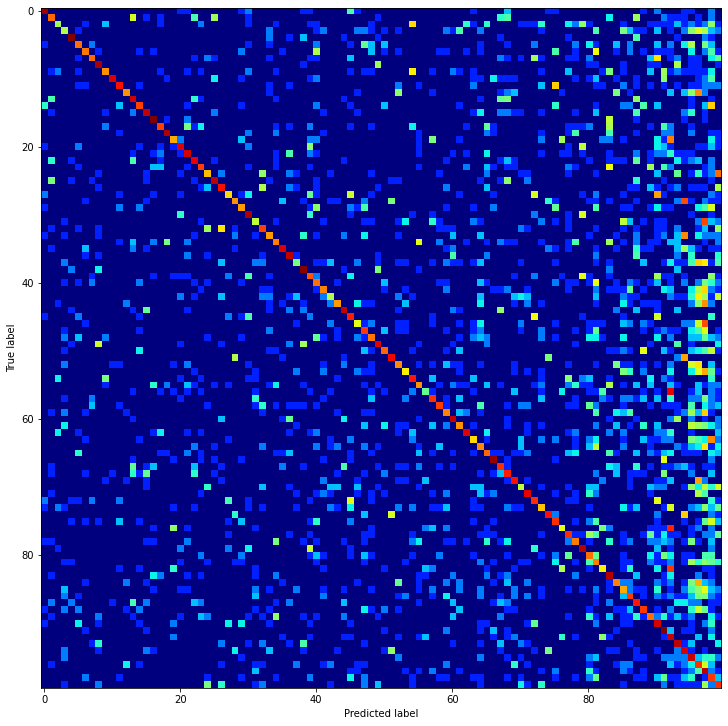

In [14]:
plot_confusion_matrix(cm, test_set.classes, normalize=True)